**Exercise 1 – Segment vessels using intensity thresholding**



In [ ]:
#!pip install imutils
import keras
import tensorflow
import os
from google.colab import drive
drive.mount("/content/drive")
from keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.layers import BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.utils import shuffle
from cv2 import imread
import numpy as np
import pandas as pd

Mounted at /content/drive


1.1 Load the RGB images of the retina, display them and compute the histogram 
of each of the colour channels image.

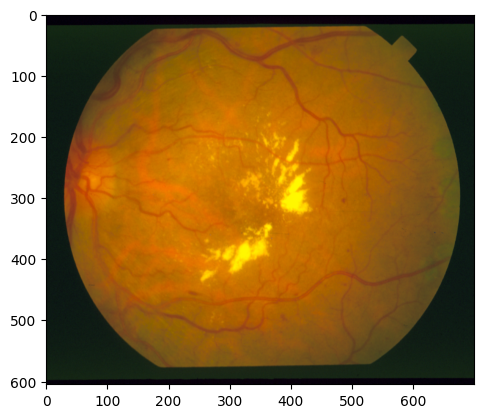

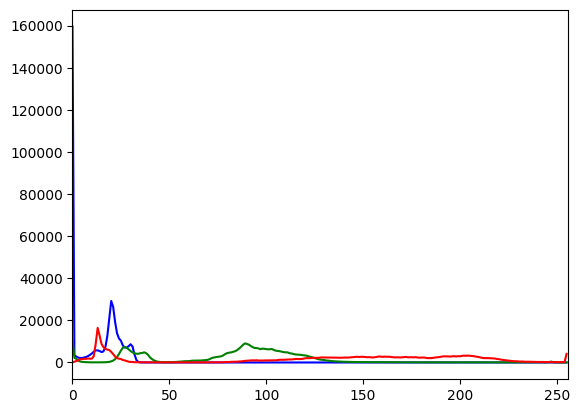

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the RGB image
img = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Compute the histogram of each color channel
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)
    plt.xlim([0, 256])

plt.show()








1.2. Choose on of the colour channels and use one of the methods available in 
OpenCV or scikit-image to define a threshold (e.g. Otsu)
Use the threshold to identify dark regions (vessels and others) from bright 
regions.


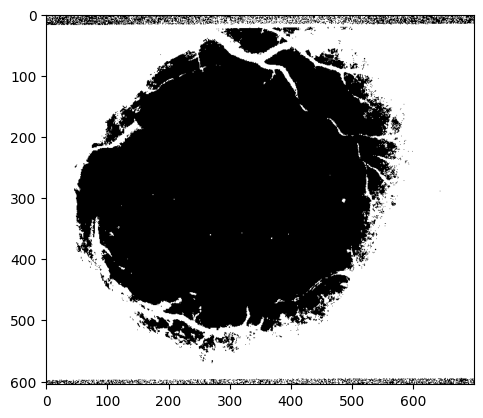

In [ ]:
# Extract the blue channel
blue_channel = img[:,:,0]

# Apply Otsu's thresholding method to the blue channel
ret, thresh = cv2.threshold(blue_channel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Display the thresholded image
plt.imshow(thresh, cmap='gray')
plt.show()

1.3. Load the images containing the labelled vessels, and compute both Dice and 
Jaccard similarity index comparing the thresholded image (segmentation) 
with the manual labelling to evaluate how well the vessels have been 
segmented.


In [ ]:
import cv2
import numpy as np

# Load the thresholded image
thresh_img = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)

# Load the labeled image
label_img = cv2.imread('/content/drive/MyDrive/Coursework/im0077_label.ppm', cv2.IMREAD_GRAYSCALE)

# Compute the intersection and union of the two images
intersection = np.logical_and(thresh_img, label_img)
union = np.logical_or(thresh_img, label_img)

# Compute the Dice similarity index
dice = (2. * intersection.sum()) / (thresh_img.sum() + label_img.sum())

# Compute the Jaccard similarity index
jaccard = intersection.sum() / union.sum()

# Print the Dice and Jaccard similarity indices
print("Dice similarity index: {:.3f}".format(dice))
print("Jaccard similarity index: {:.3f}".format(jaccard))

Dice similarity index: 0.001
Jaccard similarity index: 0.082


1.4. Define a vector of possible threshold values between 0 and 255, spaced 10. 
For each of these values:
- use the threshold to segment the image
- compute the Jaccard index between the segmentation and the labelled 
image
- Finally display a plot with the threshold values on the x-axis and the 
corresponding Jaccard index on the y axis.


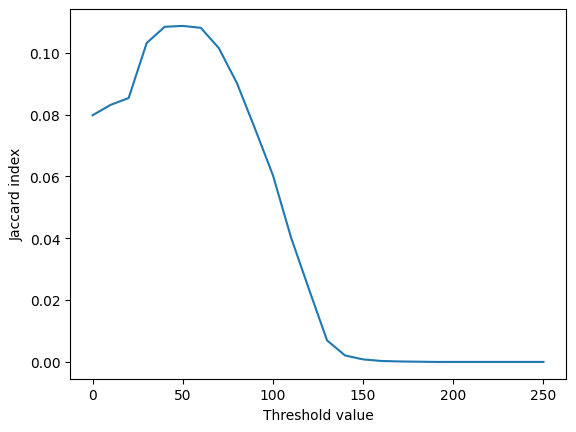

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the thresholded image
label_img = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)

# Initialize the threshold vector
thresholds = np.arange(0, 256, 10)

# Initialize the Jaccard index vector
jaccard_indices = []

# Loop over the threshold values
for threshold in thresholds:
    # Load the grayscale image
    img = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm', cv2.IMREAD_GRAYSCALE)

    # Apply the threshold
    ret, thresh_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

    # Compute the intersection and union of the two images
    intersection = np.logical_and(thresh_img, label_img)
    union = np.logical_or(thresh_img, label_img)

    # Compute the Jaccard similarity index
    jaccard = intersection.sum() / union.sum()

    # Append the Jaccard index to the vector
    jaccard_indices.append(jaccard)

# Plot the Jaccard indices as a function of the threshold values
plt.plot(thresholds, jaccard_indices)
plt.xlabel('Threshold value')
plt.ylabel('Jaccard index')
plt.show()

1.5. Apply some morphological operators to remove noise and small segmented 
objects from the segmentation and compute the Dice and Jaccard similarity 
index comparing the new segmentation with the manual labelling.


In [ ]:
# Apply morphological opening to remove noise and small objects
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

intersection = np.logical_and(opening, label_img)
union = np.logical_or(opening, label_img)

# Compute the Dice and Jaccard similarity indices
dice_index = 2 * intersection.sum() / (opening.sum() + label_img.sum())
jaccard_index = intersection.sum() / union.sum()

# Print the results
print("Dice similarity index: ", dice_index)
print("Jaccard similarity index: ", jaccard_index)

Dice similarity index:  0.0015068589859033852
Jaccard similarity index:  0.07980986743613841


**Exercise 2 – Segment vessels by learning intensity 
distribution**

2.1 Load one of the RGB images and its corresponding labelled image. Select the 
green channel of the image of the retina. On the green channel:
- compute and display the histogram of the pixels corresponding to the 
manually annotated vessels (those with a value of 255 in the annotated 
image).
- compute and display the histogram of the pixels corresponding to the 
background (those not manually annotated, having a value of 0 in the 
annotated image).


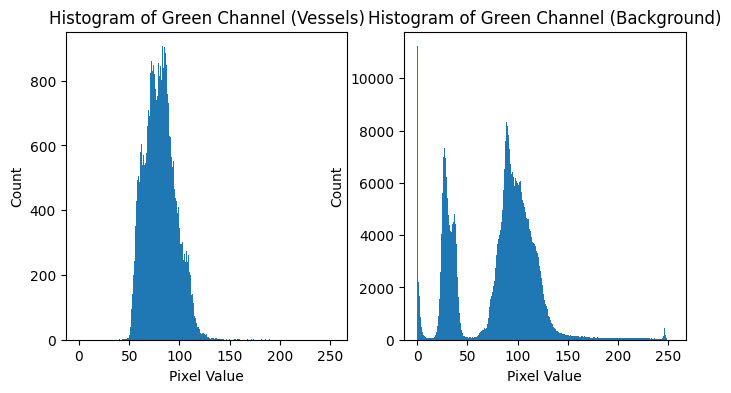

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the RGB image and labeled image
img = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')
label_img = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)

# Select the green channel of the image
green_channel = img[:, :, 1]

# Compute the histogram of the green channel for the annotated vessels
vessels_mask = (label_img == 255)
vessels_pixels = green_channel[vessels_mask]
vessels_hist, bins = np.histogram(vessels_pixels, bins=256, range=(0, 255))

# Compute the histogram of the green channel for the background
background_mask = (label_img == 0)
background_pixels = green_channel[background_mask]
background_hist, bins = np.histogram(background_pixels, bins=256, range=(0, 255))

# Display the histograms
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.bar(bins[:-1], vessels_hist, width=1)
plt.title('Histogram of Green Channel (Vessels)')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.subplot(122)
plt.bar(bins[:-1], background_hist, width=1)
plt.title('Histogram of Green Channel (Background)')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()







2.2 Using the intensity distribution of vessels and background obtained in the 
previous step, define a threshold to separate the vessels from the 
background.


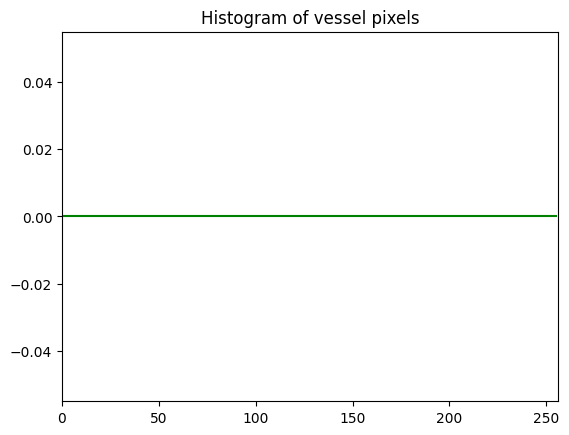

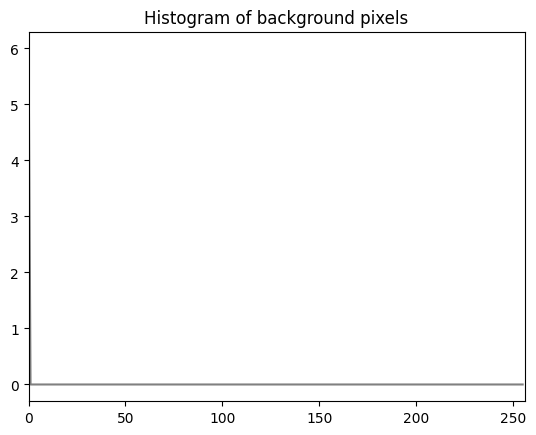

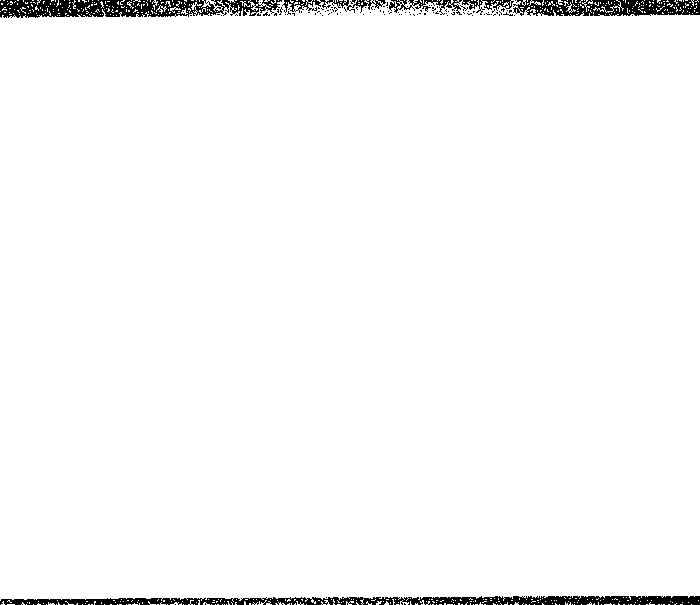

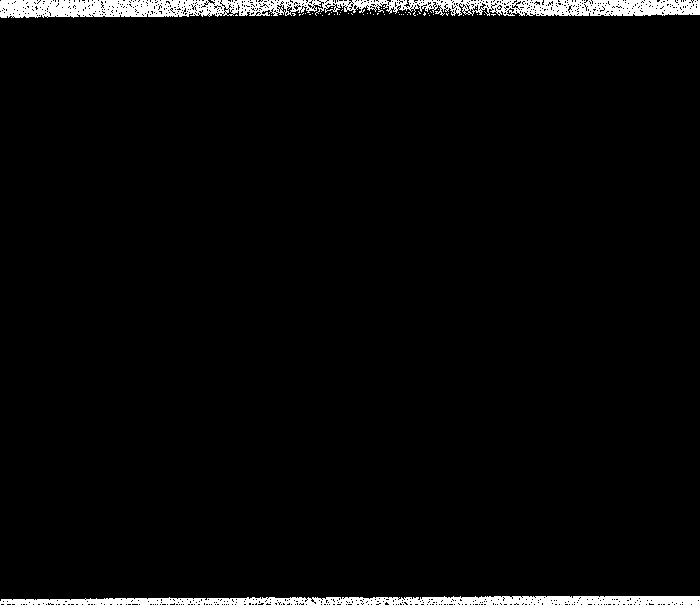

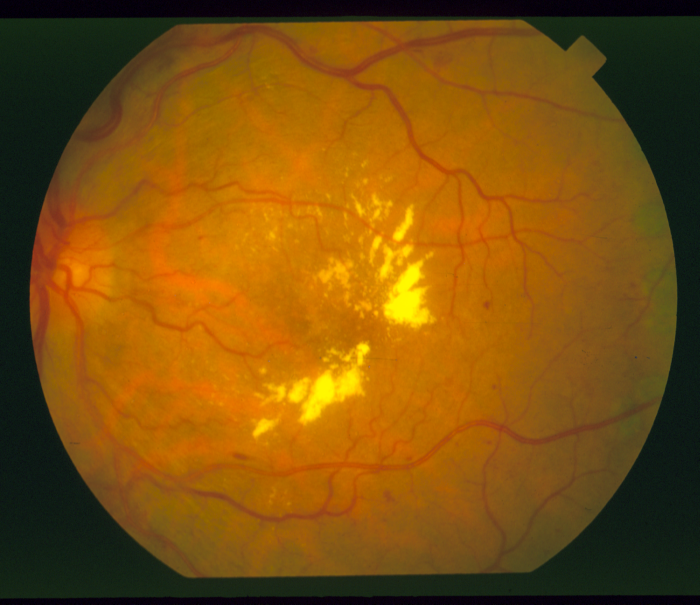

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Load the RGB image and its corresponding labelled image
img = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')
annotated_img = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm', 0)

# Select the green channel of the image
green_channel = img[:, :, 1]

# Compute and display the histogram of the pixels corresponding to the manually annotated vessels
vessel_pixels = green_channel[annotated_img == 255]
vessel_hist = cv2.calcHist([vessel_pixels], [0], None, [256], [0, 256])
plt.plot(vessel_hist, color='green')
plt.xlim([0, 256])
plt.title('Histogram of vessel pixels')
plt.show()

# Compute and display the histogram of the pixels corresponding to the background
background_pixels = green_channel[annotated_img == 0]
background_hist = cv2.calcHist([background_pixels], [0], None, [256], [0, 256])
plt.plot(background_hist, color='gray')
plt.xlim([0, 256])
plt.title('Histogram of background pixels')
plt.show()

# Define threshold based on histograms
vessel_threshold = np.argmax(vessel_hist)
background_threshold = np.argmin(background_hist)

# Create binary mask for vessels and background
vessel_mask = cv2.threshold(green_channel, vessel_threshold, 255, cv2.THRESH_BINARY)[1]
background_mask = cv2.threshold(green_channel, background_threshold, 255, cv2.THRESH_BINARY_INV)[1]

# Show masks and original image
cv2_imshow(vessel_mask)
cv2_imshow(background_mask)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


2.3. Apply the threshold to the green channel of the image and compute both Dice 
and Jaccard similarity index between the segmentation and the labelled image 
to evaluate how well the vessels have been segmented. 


In [ ]:
import cv2
import numpy as np

# Load the image and split into channels
img = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')
b, g, r = cv2.split(img)

# Apply threshold to the green channel
_, thresh = cv2.threshold(g, 120, 255, cv2.THRESH_BINARY)

# Convert the thresholded image to binary format
thresh = np.uint8(thresh)

# Load the labeled image
label = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)

# Compute Dice and Jaccard similarity indices
intersection = np.logical_and(thresh, label)
dice = 2.0 * intersection.sum() / (thresh.sum() + label.sum())
jaccard = intersection.sum() / (thresh.sum() + label.sum() - intersection.sum())

# Print the results
print("Dice Similarity Index:", dice)
print("Jaccard Similarity Index:", jaccard)

Dice Similarity Index: 2.3800110214529078e-05
Jaccard Similarity Index: 1.1900196720261298e-05


2.4. Load the other retina image and its corresponding labelled image. Apply the 
threshold to the green channel of the image and compute both Dice and 
Jaccard similarity index between the segmentation and the labelled image to 
evaluate how well the vessels have been segmented.

In [ ]:
import cv2
import numpy as np

# Load the image and split into channels
img = cv2.imread('/content/drive/MyDrive/Coursework/im0077.ppm')
b, g, r = cv2.split(img)

# Apply threshold to the green channel
_, thresh = cv2.threshold(g, 120, 255, cv2.THRESH_BINARY)

# Convert the thresholded image to binary format
thresh = np.uint8(thresh)

# Load the labeled image
label = cv2.imread('/content/drive/MyDrive/Coursework/im0077_label.ppm', cv2.IMREAD_GRAYSCALE)

# Compute Dice and Jaccard similarity indices
intersection = np.logical_and(thresh, label)
dice = 2.0 * intersection.sum() / (thresh.sum() + label.sum())
jaccard = intersection.sum() / (thresh.sum() + label.sum() - intersection.sum())

# Print the results
print("Dice Similarity Index:", dice)
print("Jaccard Similarity Index:", jaccard)

Dice Similarity Index: 9.223630480913562e-05
Jaccard Similarity Index: 4.6120279386641506e-05


2.5. Apply some morphological operators to remove noise and small segmented 
objects from the segmentation and compute the Dice and Jaccard similarity 
index comparing the new segmentation with the manual labelling.

In [ ]:
import cv2
import numpy as np

# Load the segmented image
seg_img = cv2.imread('/content/drive/MyDrive/Coursework/im0077.ppm', cv2.IMREAD_GRAYSCALE)

# Define a structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Perform morphological opening to remove noise
opened_img = cv2.morphologyEx(seg_img, cv2.MORPH_OPEN, kernel)

# Perform morphological closing to remove small objects
closed_img = cv2.morphologyEx(opened_img, cv2.MORPH_CLOSE, kernel)

# Load the labeled image
label = cv2.imread('/content/drive/MyDrive/Coursework/im0077_label.ppm', cv2.IMREAD_GRAYSCALE)

# Compute Dice and Jaccard similarity indices
intersection = np.logical_and(closed_img, label)
dice = 2.0 * intersection.sum() / (closed_img.sum() + label.sum())
jaccard = intersection.sum() / (closed_img.sum() + label.sum() - intersection.sum())

# Print the results
print("Dice Similarity Index:", dice)
print("Jaccard Similarity Index:", jaccard)


Dice Similarity Index: 0.0013185146596912537
Jaccard Similarity Index: 0.0006596922367881717


**Exercise 3 – Enhance vessels with Gabor filters**

3.1. Load one of the RGB images and its corresponding labelled image. Select the 
green channel of the image of the retina. Create a filter bank of Gabor filters 
at different orientation and scale to match the size of vessels you see in the 
image

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the RGB image and its corresponding labelled image
img_rgb = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')
img_labelled = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)

# Select the green channel of the RGB image
img_green = img[:, 1]

# Define the range of orientations and scales for the Gabor filters
orientations = [0, 45, 90, 135]
scales = [10, 20, 30]

# Create an empty list to store the filter responses
filter_responses = []

# Loop over the orientations and scales to create the filters
for orientation in orientations:
    for scale in scales:
        # Calculate the parameters for the Gabor filter
        sigma = 0.56 * scale
        lambd = scale / np.pi * np.sqrt(2)
        gamma = 0.3
        psi = 0
        
        # Create the Gabor filter
        kernel = cv2.getGaborKernel((int(scale), int(scale)), sigma, orientation, lambd, gamma, psi, ktype=cv2.CV_32F)
        
        # Apply the filter to the green channel of the image
        filtered = cv2.filter2D(img_green, cv2.CV_8UC3, kernel)
        
        # Store the filter response in the list
        filter_responses.append(filtered)

# Show the results
cv2_imshow(img_green)
for i, response in enumerate(filter_responses):
    cv2_imshow(response)
cv2.waitKey(0)
cv2.destroyAllWindows()

3.2 . On the green channel:
- apply the filters in the filter bank to the image and create an image 
containing at each pixel the maximum response among all filters
- compute and display the histogram of the maximum response image, both 
for the pixels corresponding to the manually annotated vessels (those with 
a value of 255 in the annotated image), and for the pixels corresponding to 
the background (those not manually annotated, having a value of 0 in the 
annotated image).

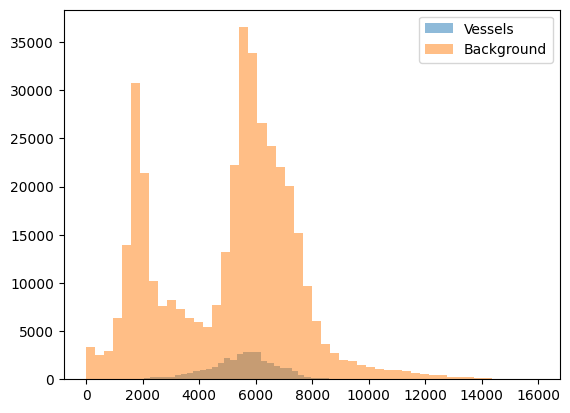

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the green channel of the RGB image
img_rgb = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')
img_green = img_rgb[:, :, 1]

# Define the range of orientations and scales for the Gabor filters
orientations = [0, 45, 90, 135]
scales = [10, 20, 30]

# Create an empty list to store the filter kernels
filter_kernels = []

# Loop over the orientations and scales to create the kernels
for orientation in orientations:
    for scale in scales:
        # Calculate the parameters for the Gabor filter
        sigma = 0.56 * scale
        lambd = scale / np.pi * np.sqrt(2)
        gamma = 0.3
        psi = 0
        
        # Create the Gabor filter
        kernel = cv2.getGaborKernel((int(scale), int(scale)), sigma, orientation, lambd, gamma, psi, ktype=cv2.CV_32F)
        
        # Store the filter kernel in the list
        filter_kernels.append(kernel)

# Apply the filters to the green channel of the image
filter_responses = []
for kernel in filter_kernels:
    filtered = cv2.filter2D(img_green, cv2.CV_32F, kernel)
    filter_responses.append(filtered)

# Create an image containing the maximum response at each pixel
max_response = np.max(filter_responses, axis=0)

# Load the labelled image and create binary masks for the vessel and background pixels
img_labelled = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)
vessel_mask = (img_labelled == 255)
background_mask = (img_labelled == 0)

# Compute and display the histogram of the maximum response image for the vessel and background pixels
plt.hist(max_response[vessel_mask], bins=50, alpha=0.5, label='Vessels')
plt.hist(max_response[background_mask], bins=50, alpha=0.5, label='Background')
plt.legend()
plt.show()


3.3. Using the histogram of the filter response of vessels and background obtained 
in the previous step, define a threshold to separate the vessels from the 
background.

Threshold: 5320.1025390625


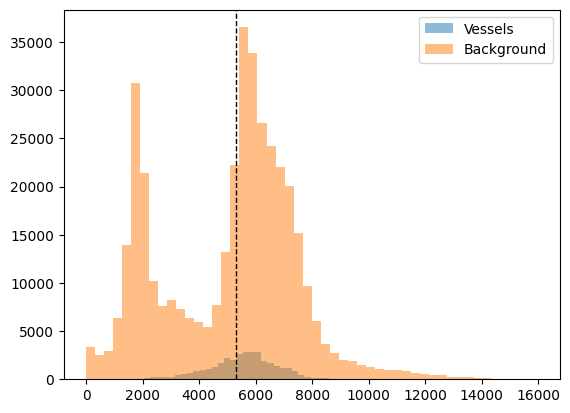

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the green channel of the RGB image
img_rgb = cv2.imread('/content/drive/MyDrive/Coursework/im0001.ppm')
img_green = img_rgb[:, :, 1]

# Define the range of orientations and scales for the Gabor filters
orientations = [0, 45, 90, 135]
scales = [10, 20, 30]

# Create an empty list to store the filter kernels
filter_kernels = []

# Loop over the orientations and scales to create the kernels
for orientation in orientations:
    for scale in scales:
        # Calculate the parameters for the Gabor filter
        sigma = 0.56 * scale
        lambd = scale / np.pi * np.sqrt(2)
        gamma = 0.3
        psi = 0
        
        # Create the Gabor filter
        kernel = cv2.getGaborKernel((int(scale), int(scale)), sigma, orientation, lambd, gamma, psi, ktype=cv2.CV_32F)
        
        # Store the filter kernel in the list
        filter_kernels.append(kernel)

# Apply the filters to the green channel of the image
filter_responses = []
for kernel in filter_kernels:
    filtered = cv2.filter2D(img_green, cv2.CV_32F, kernel)
    filter_responses.append(filtered)

# Create an image containing the maximum response at each pixel
max_response = np.max(filter_responses, axis=0)

# Load the labelled image and create binary masks for the vessel and background pixels
img_labelled = cv2.imread('/content/drive/MyDrive/Coursework/im0001_label.ppm', cv2.IMREAD_GRAYSCALE)
vessel_mask = (img_labelled == 255)
background_mask = (img_labelled == 0)

# Compute the mean filter response for the vessel and background pixels
vessel_mean = np.mean(max_response[vessel_mask])
background_mean = np.mean(max_response[background_mask])

# Define the threshold as the midpoint between the two means
threshold = (vessel_mean + background_mean) / 2

# Display the threshold and the histograms
print(f'Threshold: {threshold}')
plt.hist(max_response[vessel_mask], bins=50, alpha=0.5, label='Vessels')
plt.hist(max_response[background_mask], bins=50, alpha=0.5, label='Background')
plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

3.4. Apply the threshold to the maximum response image and compute both Dice 
and Jaccard similarity index between the segmentation and the labelled image 
to evaluate how well the vessels have been segmented

In [ ]:
import numpy as np
import cv2

# Load the maximum response image and the labelled image
max_resp_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001.ppm", 0)  # maximum response image
labelled_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001_label.ppm", 0)  # labelled image

# Apply the threshold to the maximum response image
thresh = 100  # define the threshold value
max_resp_img_thresh = np.zeros_like(max_resp_img)
max_resp_img_thresh[max_resp_img > thresh] = 255

# Compute the Dice similarity index
dice_num = 2 * np.sum(max_resp_img_thresh[labelled_img == 255])
dice_den = np.sum(max_resp_img_thresh) + np.sum(labelled_img == 255)
dice = dice_num / dice_den

# Compute the Jaccard similarity index
jaccard_num = np.sum(max_resp_img_thresh & labelled_img)
jaccard_den = np.sum(max_resp_img_thresh | labelled_img)
jaccard = jaccard_num / jaccard_den

print("Dice similarity index:", dice)
print("Jaccard similarity index:", jaccard)

Dice similarity index: 0.13382282172726234
Jaccard similarity index: 0.06038719843920009


3.5. Load the other retina image and its corresponding labelled image. Apply the 
filter bank to this image, compute its maximum response image, and apply 
the threshold found in 3.4 Compute both Dice and Jaccard similarity index 
between the segmentation and the labelled image to evaluate how well the 
vessels have been segmented. 

In [ ]:
import numpy as np
import cv2

# Load the retina image and the labelled image
retina_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001.ppm")
labelled_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001_label.ppm", 0)

# Extract the green channel from the retina image
green_channel = retina_img[:, :, 1]

# Define the filter bank
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
scales = [5, 10, 15, 20]
filter_bank = []
for scale in scales:
    for orientation in orientations:
        kernel = cv2.getGaborKernel((scale, scale), 1.0, orientation, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        filter_bank.append(kernel)

# Apply the filter bank to the green channel and compute the maximum response image
max_resp_img = np.zeros_like(green_channel)
for kernel in filter_bank:
    filtered_img = cv2.filter2D(green_channel, cv2.CV_32F, kernel)
    max_resp_img = np.maximum(max_resp_img, filtered_img)

# Apply the threshold found in the previous task to the maximum response image
thresh = 100  # threshold value found in previous task
max_resp_img_thresh = np.zeros_like(max_resp_img)
max_resp_img_thresh[max_resp_img > thresh] = 255

# Compute the Dice similarity index
dice_num = 2 * np.sum(max_resp_img_thresh[labelled_img == 255])
dice_den = np.sum(max_resp_img_thresh) + np.sum(labelled_img == 255)
dice = dice_num / dice_den

# Compute the Jaccard similarity index
jaccard_num = np.sum(max_resp_img_thresh + labelled_img)
jaccard_den = np.sum(max_resp_img_thresh - labelled_img)
jaccard = jaccard_num / jaccard_den

print("Dice similarity index:", dice)
print("Jaccard similarity index:", jaccard)

Dice similarity index: 0.16567669875902674
Jaccard similarity index: 1.1807046


3.6. Apply some morphological operators to remove noise and small segmented 
objects from the segmentation and compute the Dice and Jaccard similarity 
index comparing the new segmentation with the manual labelling.


In [ ]:
import cv2
import numpy as np

# Load the segmented image
segmented_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001.ppm", 0)

# Apply morphological operations to remove noise and small objects
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opening = cv2.morphologyEx(segmented_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# Compute the Dice similarity index
dice_num = 2 * np.sum(closing[labelled_img == 255])
dice_den = np.sum(closing) + np.sum(labelled_img == 255)
dice = dice_num / dice_den

# Compute the Jaccard similarity index
jaccard_num = np.sum(closing & labelled_img)
jaccard_den = np.sum(closing | labelled_img)
jaccard = jaccard_num / jaccard_den

print("Dice similarity index after morphological operations:", dice)
print("Jaccard similarity index after morphological operations:", jaccard)

Dice similarity index after morphological operations: 0.17991901972011967
Jaccard similarity index after morphological operations: 0.07845176418426525


**Exercise 4 – Apply learning pipeline**

4.1. Load one of the RGB images and its corresponding labelled image. Select the 
green channel of the image of the retina.


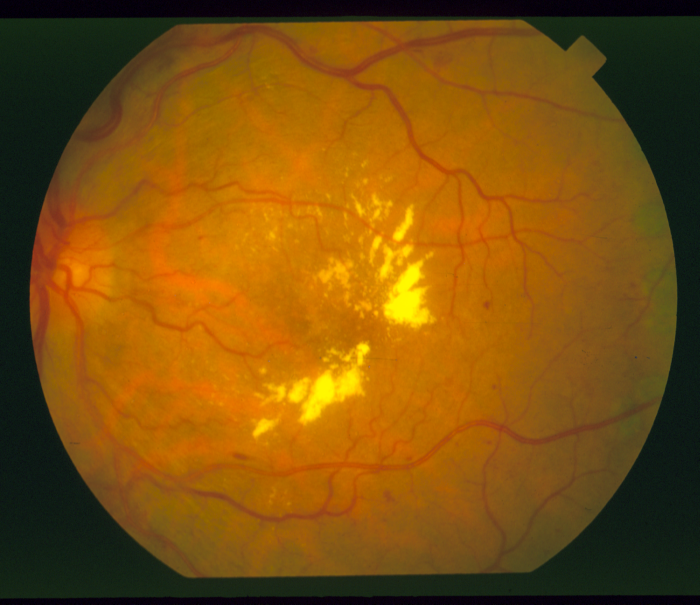

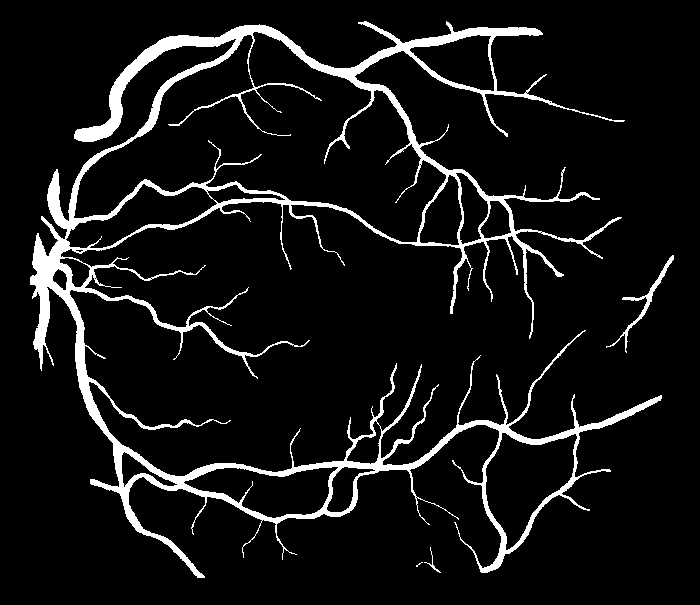

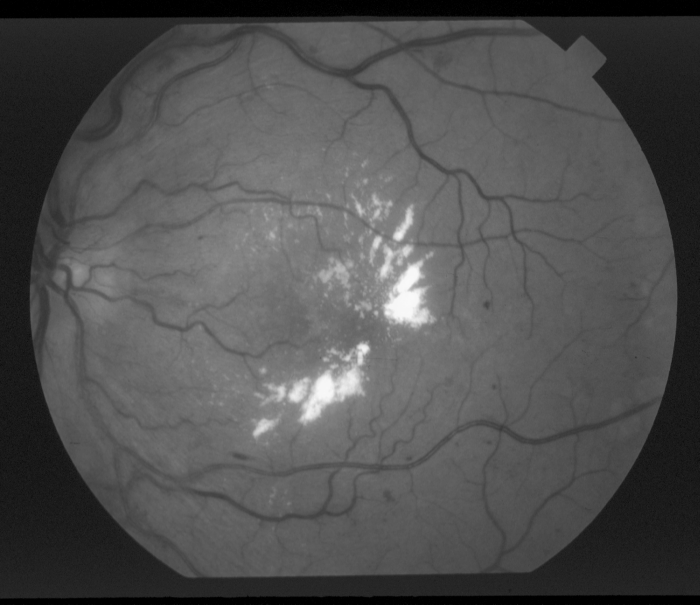

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the RGB image
rgb_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001.ppm")

# Load the labelled image
labelled_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001_label.ppm", 0)

# Select the green channel of the RGB image
green_img = rgb_img[:, :, 1]

# Display the images for verification
cv2_imshow(rgb_img)
cv2_imshow(labelled_img)
cv2_imshow(green_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

4.2  Divide the image in squares of 11x11 pixels. For each square compute a 
feature descriptor of your choice (e.g. GLCM-based, HoG, SIFT, …). Assign to 
each square a label: 0 if the pixel corresponding to its central position in the 
labelled image is 0, 1 if the pixel corresponding to its central position in the 
labelled image is 255.

In [ ]:
import cv2
from skimage.feature import local_binary_pattern


# Define the size of the square and the stride between squares
square_size = 11
stride = 1

# Initialize lists to hold the feature vectors and labels
features = []
labels = []

# Loop over each square in the image
for i in range(0, green_img.shape[0]-square_size, stride):
    for j in range(0, green_img.shape[1]-square_size, stride):
        
        # Extract the current square from the image
        square = green_img[i:i+square_size, j:j+square_size]
        
        # Compute the LBP feature vector for the square
        lbp = local_binary_pattern(square, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
        
        # Append the feature vector and label to the lists
        features.append(hist)
        if labelled_img[i+square_size//2, j+square_size//2] == 0:
            labels.append(0)
        else:
            labels.append(1)

# Convert the lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

4.3. Train a SVM (use scikit-learn) classifier to classify squares centered on vessels 
from squares centered on background

In [ ]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# Load the image and the labelled image
img = cv2.imread("/content/drive/MyDrive/Coursework/im0001.ppm", 0)
labelled_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001_label.ppm", 0)

# Define the square size
square_size = 11

# Compute the number of squares in each dimension
num_rows, num_cols = img.shape
num_squares_rows = num_rows // square_size
num_squares_cols = num_cols // square_size

# Extract HoG features for each square
X = []
y = []
for row in range(num_squares_rows):
    for col in range(num_squares_cols):
        # Compute the coordinates of the square
        square_row_start = row * square_size
        square_col_start = col * square_size
        square_row_end = square_row_start + square_size
        square_col_end = square_col_start + square_size
        
        # Extract the square
        square_img = img[square_row_start:square_row_end, square_col_start:square_col_end]
        
        # Compute the HoG features for the square
        hog_features = hog(square_img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), block_norm='L2-Hys')
        
        # Determine the label for the square
        label = labelled_img[square_row_start+square_size//2, square_col_start+square_size//2] == 255
        
        # Append the features and label to the dataset
        X.append(hog_features)
        y.append(int(label))

# Convert the dataset to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the data to improve the SVM performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Test the SVM
y_pred = svm.predict(X_test)

# Evaluate the SVM
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.924963924963925


4.4. Apply the pipeline and the trained classifier on the other image, and compute 
both Dice and Jaccard similarity index to evaluate how well the vessels have 
been segmented

In [ ]:
# Define the square size
square_size = 11

# Compute the number of squares in each dimension
num_rows, num_cols = img.shape
num_squares_rows = num_rows // square_size
num_squares_cols = num_cols // square_size

pred_img = np.zeros(img.shape, dtype=np.uint8)
for row in range(num_squares_rows):
    for col in range(num_squares_cols):
        # Compute the coordinates of the square
        square_row_start = row * square_size
        square_col_start = col * square_size
        square_row_end = square_row_start + square_size
        square_col_end = square_col_start + square_size
        
        # Determine the predicted label for the square
        label = y_pred[400]
        
        # Set the corresponding pixels in the predicted image
        pred_img[square_row_start:square_row_end, square_col_start:square_col_end] = 255 if label else 0

# Compute the Dice and Jaccard similarity indices
labelled_img = cv2.imread("/content/drive/MyDrive/Coursework/im0001_label.ppm", 0)
intersection = np.logical_and(pred_img, labelled_img)
union = np.logical_or(pred_img, labelled_img)
dice = 2 * intersection.sum() / (pred_img.sum() + labelled_img.sum())
jaccard = intersection.sum() / union.sum()

print("Dice Similarity Index:", dice)
print("Jaccard Similarity Index:", jaccard)

Dice Similarity Index: 0.0
Jaccard Similarity Index: 0.0
